In [1]:
import sys
print('iPython Kernel -->', sys.argv)
print('Environment -->', sys.prefix)

iPython Kernel --> ['C:\\anaconda3\\envs\\ling\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Babak Ravandi\\AppData\\Roaming\\jupyter\\runtime\\kernel-5d50398c-c912-487d-ac7d-450cfa07688f.json']
Environment --> C:\anaconda3\envs\ling


In [2]:
import pandas as pd
import numpy as np
import json
from collections import OrderedDict 

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

import networkx as nx
import GraphHierarchy as gh

from tqdm import tqdm

from scipy import stats

import gspread

'''
This layout algorithm requires installin graphviz
https://pygraphviz.github.io/documentation/stable/install.html
'''
from networkx.drawing.nx_agraph import graphviz_layout

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

In [3]:
import os
from pandas import ExcelWriter


def save_xls(dfs_dict, xls_path, open=False):
    if type(dfs_dict) is not dict:
        dfs_dict = {'sheet1': dfs_dict}
    
    with ExcelWriter(xls_path) as writer:
        for df_name, df in dfs_dict.items():
            df.to_excel(writer, df_name)
        writer.save()

    if open is True:
        os.system('start EXCEL.EXE "{}"'.format(os.path.abspath(xls_path)))
    pass

In [5]:
# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [6]:
def lenght_all_pairs_shortest_path(G_nx):
    q = nx.all_pairs_shortest_path(G_nx)
    
    p_all = []

    for p in q:
        p_all.append(p)

    p_lenght = []
    path_df = []
    
    for p_2 in [p[1].values() for p in p_all]:
        for p3 in p_2:
            p_lenght.append(len(p3))
            
            path_df.append({'l': len(p3), 'p': p3})
#         p_lenght += [len(p3) for p3 in p_2]

        pass
    
    path_df = pd.DataFrame(path_df)
    path_df['p'] = path_df['p'].astype('str')
    
    return path_df

In [7]:
path_results_output = "D:/GoogleDrive/Research/Linguistic project/German/data/output/"
path_data_explorer_data = 'D:/SoftwareProject/data_explorer/data/'

# path_dataset_dir = "D:/GoogleDrive/Research/Linguistic project/German/data/legacy/"

# Load Networks

In [8]:
centuries = {
    '11': 11.0, '12': 12.0, '13': 13.0, '14E': 14.1, '14L': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
}

## Check Mistake Duplicate Edges & Add Frequency

THe only exception of having multiple interactions between a source and target is in 17th century as below. ALl other centuries must have only a single interaction (type of edge) between two nodes.

Source:'PR ze'	 |	Target: 'IV werden'   |   Interactions: {PP, VP}

In [9]:
gc = gspread.service_account(filename='google_service_credentials.json')

In [10]:
google_sheet_ID = '1CWbPlXrKa41DL02mO6pny8BC4Hd7xwbIhA3-ZthyjWc'

german_dataset_gsheet = gc.open_by_key(google_sheet_ID)

german_dataset_gsheet.worksheets()

[<Worksheet '11' id:2063048793>,
 <Worksheet '12' id:936686375>,
 <Worksheet '13' id:698480864>,
 <Worksheet '14E' id:1758104757>,
 <Worksheet '14L' id:1538902914>,
 <Worksheet '15' id:2099895106>,
 <Worksheet '16' id:121866148>,
 <Worksheet '17' id:1360439213>,
 <Worksheet 'Descriptions' id:646251015>,
 <Worksheet 'Shortkeys!' id:1846877574>]

In [11]:
cent_interaction_validate = {}
cent_raw_df = {}
cent_df_dict = {}
'''This is to have the option of more complex network'''
enforce_single_function = True

for cent in centuries.keys():

    print('------------ Cent:', cent)
    
    cent_df = pd.DataFrame(german_dataset_gsheet.worksheet(cent).get_all_records())

    cent_df.loc[:, ['Source', 'Target', 'Interaction']] = (
        cent_df.loc[:, ['Source', 'Target', 'Interaction']].apply(lambda x: x.str.strip(), axis=1)
    ) 
    
    cent_df['Source Funcs All'] = cent_df['Source'].apply(lambda x: x.split(' ')[0])
    cent_df['Source Func Single'] = cent_df['Source Funcs All'].apply(lambda x: x.split('/')[0])

    cent_df['Target Funcs All'] = cent_df['Target'].apply(lambda x: x.split(' ')[0])
    cent_df['Target Func Single'] = cent_df['Target Funcs All'].apply(lambda x: x.split('/')[0])

    cent_df['Source Single Func'] = cent_df['Source Func Single'] + ' ' + cent_df['Source'].apply(lambda x: ' '.join(x.split(' ')[1:]))
    cent_df['Target Single Func'] = cent_df['Target Func Single'] + ' ' + cent_df['Target'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    cent_df['Source All Funcs'] = cent_df['Source']
    cent_df['Target All Funcs'] = cent_df['Target']

    if enforce_single_function is True:
        cent_df['Source'] = cent_df['Source Single Func']
        cent_df['Target'] = cent_df['Target Single Func']

    cent_raw_df[cent] = cent_df.copy()
    
    """"""
    G=nx.from_pandas_edgelist(
        cent_df, source='Source', target='Target', 
        edge_attr=True, create_using=nx.DiGraph()
    )
    
    # nx.draw(G, with_labels=True)
    # print(type(G))
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    print('num raw edges in dataset:', len(cent_df), ' num network edges:', G.number_of_edges())
    """"""

    cent_df['frequency'] = cent_df['Interaction']

    cent_df = (
        cent_df.groupby(['Source', 'Target'])
        .agg({
            'Interaction': lambda x: set([v.upper() for v in x]),
            'frequency': np.size,
         })
        .reset_index()
    )

    cent_df['Interaction count'] = cent_df['Interaction'].apply(len)

    # print(path_net)
    cent_df = cent_df.sort_values(by=['Interaction count', 'frequency'], ascending=False)

    cent_df_dict[cent] = cent_df
    
    cent_interaction_validate[cent] = cent_df[cent_df['Interaction count'] > 1]  
    
    print(
        'Interaction count > 1 -->', len(cent_interaction_validate[cent])
    )
    
    del cent_df
#     break
    pass
# cent_df_dict.keys()
# cent_df = cent_raw_df[cent]
print('IMP enforce_single_function:', enforce_single_function)

------------ Cent: 11
num raw edges in dataset: 968  num network edges: 725
Interaction count > 1 --> 0
------------ Cent: 12
num raw edges in dataset: 1194  num network edges: 803
Interaction count > 1 --> 0
------------ Cent: 13
num raw edges in dataset: 2503  num network edges: 1330
Interaction count > 1 --> 0
------------ Cent: 14E
num raw edges in dataset: 2326  num network edges: 1321
Interaction count > 1 --> 0
------------ Cent: 14L
num raw edges in dataset: 2494  num network edges: 1586
Interaction count > 1 --> 0
------------ Cent: 15
num raw edges in dataset: 2227  num network edges: 1424
Interaction count > 1 --> 0
------------ Cent: 16
num raw edges in dataset: 3346  num network edges: 2448
Interaction count > 1 --> 0
------------ Cent: 17
num raw edges in dataset: 3940  num network edges: 3083
Interaction count > 1 --> 0
IMP enforce_single_function: True


In [12]:
print('WE MUST HAVE Only two nodes with multiple edges!')
print('NOT ANYMORE! we fixed it')
cent_interaction_validate['17']

WE MUST HAVE Only two nodes with multiple edges!
NOT ANYMORE! we fixed it


,Source,Target,Interaction,frequency,Interaction count


### Check with Legacy

## Tree Specs and Validation

In [13]:
sentence_cent_df = []
G_list = {}
G_not_tree_list = {}
root_codes = [1, -1, -2] # tree, '', cycle (why cycle valentina?)

if enforce_single_function:
    type_source_target = 0
else:
    type_source_target = 1
    pass

print('type_source_target:', type_source_target)

col_source = ['Source Single Func', 'Source All Funcs'][type_source_target]
col_target = ['Target Single Func', 'Target All Funcs'][type_source_target]

for cent in centuries.keys():
#     if cent != '16':
#         continue
        
    print('------------------Cent: {} | {} -> {}------------------'.format(cent, col_source, col_target))
    
    sentence_started = False
    G = None
    row_num = 0
    root_row_num_current = None

    tree_root = None
    is_root_code = None

    G_list[cent] = []
    G_not_tree_list[cent] = []

    for source, target, is_root in cent_raw_df[cent][[col_source, col_target, 'Root']].to_numpy():
        if (sentence_started is True and is_root in root_codes) or (row_num == len(cent_raw_df[cent]) - 1):
            
            # in case no root is marked
            if G is None:
                row_num += 1
                continue
            
            sentence_started = False
           
            diameter_from_all_directed_paths = None
            diemter_from_undirected_graph = None
            diameter_from_positions = None
            
            
            is_tree = nx.is_tree(G)
            
            if(is_tree):    
                path_df = lenght_all_pairs_shortest_path(G)
                diameter_from_all_directed_paths = path_df['l'].max()
                
                diemter_from_undirected_graph = nx.diameter(G.to_undirected())
                
                pos = hierarchy_pos(G, root=tree_root)
                diameter_from_positions =  len(set([v[1] for v in pos.values()]))
                
                if is_root_code != 1:
                    G_not_tree_list[cent].append((root_row_num_current, is_root_code + -0.1, G))
            else:
                G_not_tree_list[cent].append((root_row_num_current, is_root_code, G))
    #             print('not tree')
                pass
            pass
    
            G_list[cent].append({
                'cent': cent,
                'root':tree_root, 
                'root code': is_root_code,
                'is_tree_nx': is_tree,
                'G': G,
                'diameter from all directed paths': diameter_from_all_directed_paths,
                'diameter from undirected graph': diemter_from_undirected_graph,
                'tree height from positions': diameter_from_positions
            })

        #if is_root == 1:
        if is_root in root_codes:
            is_root_code = is_root
            sentence_started = True
            root_row_num_current = row_num
            tree_root = source
            G = nx.DiGraph()
            pass
        
        # in case no root is marked
        if G is not None:
            G.add_edge(source, target)

        row_num += 1
        pass

    del is_root, is_root_code
    print('Num Sentences:', len(G_list[cent]), 'Num NOT trees:', len(G_not_tree_list[cent]))
    
    cent_tree_specs_df = pd.DataFrame(G_list[cent])
    
    if 'is_root' in cent_tree_specs_df:
        print('root code freq:\n', cent_tree_specs_df['is_root'].fillna('NA').value_counts())
    
    sentence_cent_df.append(cent_tree_specs_df)
    pass

sentence_cent_df = pd.concat(sentence_cent_df).reset_index(drop=True)

type_source_target: 0
------------------Cent: 11 | Source Single Func -> Target Single Func------------------
Num Sentences: 238 Num NOT trees: 18
------------------Cent: 12 | Source Single Func -> Target Single Func------------------
Num Sentences: 302 Num NOT trees: 14
------------------Cent: 13 | Source Single Func -> Target Single Func------------------
Num Sentences: 687 Num NOT trees: 22
------------------Cent: 14E | Source Single Func -> Target Single Func------------------
Num Sentences: 604 Num NOT trees: 51
------------------Cent: 14L | Source Single Func -> Target Single Func------------------
Num Sentences: 569 Num NOT trees: 57
------------------Cent: 15 | Source Single Func -> Target Single Func------------------
Num Sentences: 540 Num NOT trees: 38
------------------Cent: 16 | Source Single Func -> Target Single Func------------------
Num Sentences: 651 Num NOT trees: 86
------------------Cent: 17 | Source Single Func -> Target Single Func------------------
Num Sentences

In [14]:
print(len(sentence_cent_df))
sentence_cent_df.head()

4315


,cent,root,root code,is_tree_nx,G,diameter from all directed paths,diameter from undirected graph,tree height from positions
0,11,AX werden,1,True,"(AX werden, PcPs pflanzen, DM der, PR ze, N jerusalem)",4.0,4.0,4.0
1,11,AX werden,1,True,"(AX werden, PcPs beswichen, PP ich, PK niht, PR mit, N doctrina, AJ perversus)",5.0,5.0,5.0
2,11,V werden,1,True,"(V werden, AD so, N auditor, AJ din)",3.0,3.0,3.0
3,11,AX sin,1,True,"(AX sin, PcPs werden, PP ich, AJ edel, PR von, N cyprus)",4.0,3.0,4.0
4,11,AX werden,1,True,"(AX werden, PcPs geantvristen)",2.0,1.0,2.0


In [15]:
sentence_cent_df.groupby('cent').agg(
    max_diameter_directed_paths=('diameter from all directed paths', np.max),
    max_diameter_undirected_graph=('diameter from undirected graph', np.max),
    max_tree_height_from_positions=('tree height from positions', np.max)
)

,max_diameter_directed_paths,max_diameter_undirected_graph,max_tree_height_from_positions
cent,,,
11,7.0,7.0,7.0
12,6.0,7.0,6.0
13,6.0,7.0,6.0
14E,7.0,7.0,7.0
14L,6.0,7.0,6.0
15,6.0,7.0,6.0
16,7.0,9.0,7.0
17,8.0,10.0,8.0


### Export Not Trees

In [16]:
path_export_trees_dir = "D:/GoogleDrive/Research/Linguistic project/German/data/export_trees/"
cent = '11'
print('Number of NOT tree items for cent', cent, ':')
pd.DataFrame(G_not_tree_list[cent], columns=['row number', 'root code', 'tree nx'])['root code'].value_counts()
# pd.DataFrame(G_list[cent])['root code'].value_counts()

Number of NOT tree items for cent 11 :


 1    13
-2    5 
Name: root code, dtype: int64

In [17]:
'''
Export Not trees
'''

G_not_tree_list[cent] = sorted(G_not_tree_list[cent], key=lambda x: x[1], reverse=True)

limit_number_nets = 30
not_tree_df = []
num_not_tree = len(G_not_tree_list)
figs = []
ax_index = 0

for i, not_tree in tqdm(enumerate(G_not_tree_list[cent])):
    if i % limit_number_nets == 0:
        plt.close()
        
        fig, axs = plt.subplots(limit_number_nets, figsize=(10, limit_number_nets * 4), dpi=200)
        ax_index = 0
        
        figs.append(fig)
        pass

    not_tree_df.append({'row_num': row_num + 2, 'cent': cent})
    
    row_num, is_root_code, G = not_tree   

    pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

    nx.draw(G, pos=pos, with_labels = True, ax=axs[ax_index])
    axs[ax_index].set_title(
        '--------------------------------------Row Number: {} | code: {} ({} from {})--------------------------------------'.format(
        row_num + 2,
        is_root_code,
        i + 1,
        num_not_tree
    ))
    
    ax_index += 1
    pass

plt.close()

not_tree_df = pd.DataFrame(not_tree_df)
not_tree_df.to_excel(path_export_trees_dir + 'not_tree/cent_{}.xlsx'.format(cent))

for i, fig in enumerate(figs):
    path_fig = path_export_trees_dir + 'not_tree/cent_{}_part_{}.png'.format(cent, i)
    fig.savefig(path_fig, bbox_inches='tight')
    print('Saved fig at: ', path_fig)
    del fig
    pass

del figs
    
print('Cent:', cent)
# plt.tight_layout()

18it [00:05,  3.33it/s]


Saved fig at:  D:/GoogleDrive/Research/Linguistic project/German/data/export_trees/not_tree/cent_11_part_0.png
Cent: 11


Cent: 11
Tree height: 3


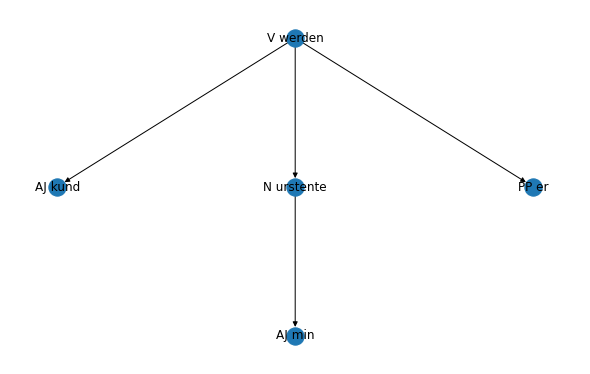

In [18]:
'''
Visualize a Tree
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
plt.figure(figsize=(8, 5)) # , dpi=100
index_tree = [52, 461, 400][0]

tree_root = G_list[cent][index_tree]['root']
G = G_list[cent][index_tree]['G']

pos = hierarchy_pos(G, root=tree_root)

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])))

Cent: 11
Tree height: 4 root code: 1


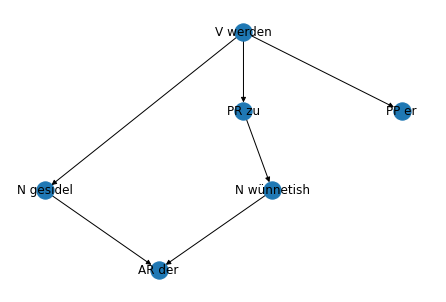

In [19]:
'''
Visualize a not tree sentence
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

row_number, root_code, G = G_not_tree_list[cent][index_tree]

pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])), 'root code:', root_code)

## Create Weighted Networks with Freq

In [20]:
cent_nets = OrderedDict()
syntactic_nets = []

for cent, cent_df in cent_df_dict.items():
    print('------- cent:', cent)
    
#     cent_df = pd.read_excel( path_dataset_dir + path_net).drop(columns='Unnamed: 0')
    
    cent_df['Source'] = cent_df['Source'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    cent_df['Target'] = cent_df['Target'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    
    cent_df.loc[:, 'Source':'Target'] = cent_df.loc[:, 'Source':'Target'].apply(
        lambda x: x.str.strip())
    
#     print(cent_df.columns)
    G = nx.from_pandas_edgelist(
        cent_df, 
        source='Source', 
        target='Target', 
        edge_attr=True,
#         edge_attr=['Interaction', 'frequency', 'Interaction count'], 
#         Created a directed graph
        create_using=nx.DiGraph()
    )
    
    cent_df['cent'] = cent
    syntactic_nets.append(cent_df)
    
    print('n:', G.number_of_nodes(), 'e:', G.number_of_edges())
    
    cent_nets[cent] = G
    pass

syntactic_nets = pd.concat(syntactic_nets).reset_index(drop=True)
syntactic_nets

------- cent: 11
n: 411 e: 723
------- cent: 12
n: 434 e: 803
------- cent: 13
n: 697 e: 1325
------- cent: 14E
n: 686 e: 1321
------- cent: 14L
n: 751 e: 1586
------- cent: 15
n: 735 e: 1424
------- cent: 16
n: 1187 e: 2448
------- cent: 17
n: 1561 e: 3083


,Source,Target,Interaction,frequency,Interaction count,cent
0,AX werden,PP er,{VP},43,1,11
1,V werden,PP er,{VP},12,1,11
2,AX sin,PCPS werden,{VP},11,1,11
3,AX werden,PK ne,{VP},9,1,11
4,AX werden,PP du,{VP},9,1,11
...,...,...,...,...,...,...
12715,V werden,PR allzu,{VP},1,1,17
12716,V werden,PR bei,{VP},1,1,17
12717,V werden,PR hinfür,{VP},1,1,17
12718,V werden,PR von,{VP},1,1,17


In [21]:
'''Check if network is connected'''

for cent, G in cent_nets.items():
    print('------------------', cent, '----------------')
    
    con_comps = [c for c in nx.connected_components(G.to_undirected())]
    
    print('num connected components:', len(con_comps))
    
    for c in con_comps:
        if len(c) < 10:
            print(c)
            
    if len(con_comps) != 1:
        raise Exception('Big PROBLEM!!!')
    pass


------------------ 11 ----------------
num connected components: 1
------------------ 12 ----------------
num connected components: 1
------------------ 13 ----------------
num connected components: 1
------------------ 14E ----------------
num connected components: 1
------------------ 14L ----------------
num connected components: 1
------------------ 15 ----------------
num connected components: 1
------------------ 16 ----------------
num connected components: 1
------------------ 17 ----------------
num connected components: 1


In [22]:
if True:
    path_syntactic_nets = path_results_output + 'syntactic_nets_german.xlsx'
    print(path_syntactic_nets)
    syntactic_nets.to_excel(path_syntactic_nets)
    pass

D:/GoogleDrive/Research/Linguistic project/German/data/output/syntactic_nets_german.xlsx


In [23]:
nodes_all_cent = set(syntactic_nets['Source']).union(set(syntactic_nets['Target']))

[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'IV werden', 'V werden', 'PCPS werden']

### Validation | TODO FIX!!!

In [24]:
if True:
    syntactic_nets.to_excel(path_results_output + 'german_ling_network.xlsx')
    print(path_results_output + 'german_ling_network.xlsx')

D:/GoogleDrive/Research/Linguistic project/German/data/output/german_ling_network.xlsx


In [25]:
syntactic_nets['Interaction str'] = syntactic_nets['Interaction'].astype(str)

syntactic_nets[syntactic_nets['Interaction str'] == "{''}"]

,Source,Target,Interaction,frequency,Interaction count,cent,Interaction str


In [26]:
'''
The ones with count = 1 seems to have an issue
'''

cent_interaction_count = syntactic_nets.groupby(['cent', 'Interaction str']).agg(
    count = ('Interaction', np.size),
#     source = ('Source', lambda x: set(x)),
#     target = ('Target', lambda x: set(x))
)
if False:
    cent_interaction_count.to_excel('cent_interaction_count.xlsx')
    pass

cent_interaction_count

count
cent Interaction str       
11   {'NP'}           164  
     {'PP'}           81   
     {'VP'}           480  
12   {'NP'}           198  
     {'PP'}           79   
     {'VP'}           526  
13   {'NP'}           321  
     {'PP'}           178  
     {'VP'}           831  
14E  {'NP'}           334  
     {'PP'}           119  
     {'VP'}           868  
14L  {'NP'}           452  
     {'PP'}           169  
     {'VP'}           965  
15   {'NP'}           370  
     {'PP'}           140  
     {'VP'}           914  
16   {'NP'}           664  
     {'PP'}           314  
     {'VP'}           1470 
17   {'NP'}           890  
     {'PP'}           420  
     {'VP'}           1773

In [27]:
G.get_edge_data('AX werden','PP er')
# cent_df
# pd.read_excel( path_dataset_dir + path_net)
# path_dataset_dir + path_net

{'Interaction': {'VP'}, 'frequency': 92, 'Interaction count': 1}

# Analyze Diameter

In [28]:
diameter_cent_df = []

for cent, cent_G in tqdm(cent_nets.items()):
    path_df = lenght_all_pairs_shortest_path(cent_nets[cent])

    diameter_cent_df.append({
        'cent': cent,
        'avg pairwise shortest path': path_df['l'].mean(),
        'sentence height avg': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].mean(),
                
        'diameter (max pairwise shortest path)': path_df['l'].max(),
        'sentence height max': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].max(),
        
        'avg pairwise shortest path std': path_df['l'].std(),
        'sentence height std': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].std()
    })
    pass

diameter_cent_df = pd.DataFrame(diameter_cent_df)
diameter_cent_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s]


,cent,avg pairwise shortest path,sentence height avg,diameter (max pairwise shortest path),sentence height max,avg pairwise shortest path std,sentence height std
0,11,3.084778,3.368182,7,7.0,1.130399,1.172706
1,12,3.108021,3.420139,6,6.0,1.108798,1.095068
2,13,4.281769,3.203008,10,6.0,1.746807,1.127153
3,14E,3.120198,3.106691,6,7.0,0.998543,0.984210
4,14L,3.459597,3.333984,8,6.0,1.110110,1.037354
5,15,3.496810,3.255952,9,6.0,1.229800,1.004940
6,16,5.083229,3.778151,17,7.0,2.459938,1.142031
7,17,6.555291,3.929688,16,8.0,2.254260,1.220480


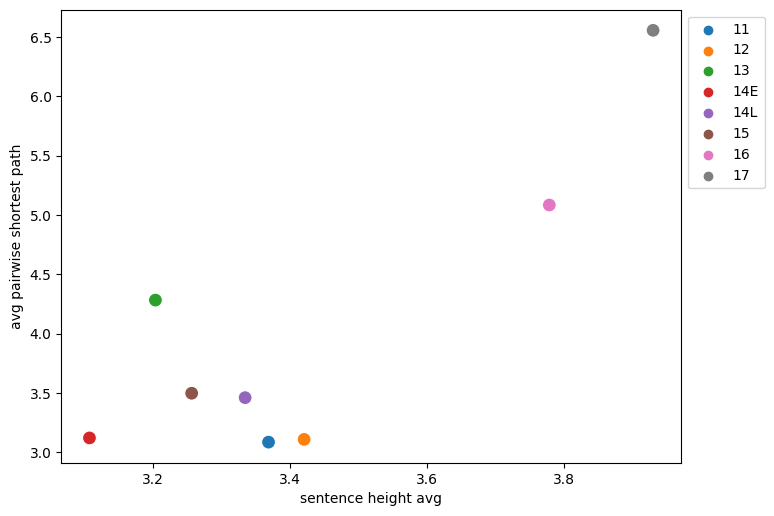

In [29]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=diameter_cent_df, x="sentence height avg", y="avg pairwise shortest path", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1, 1))

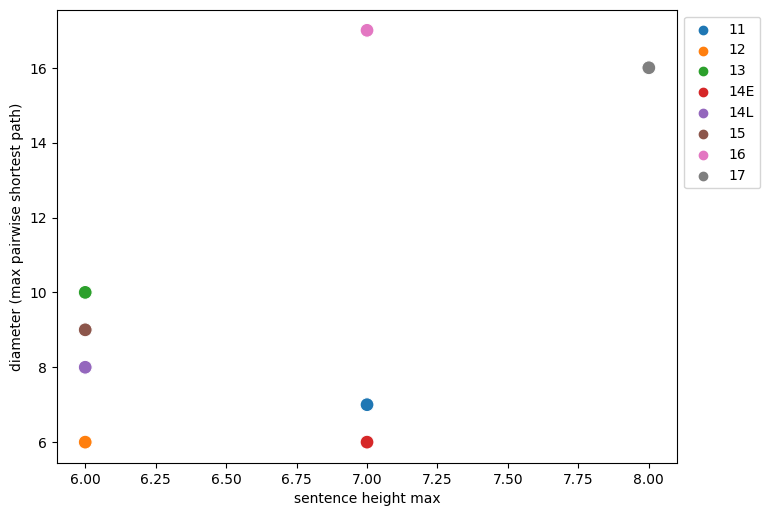

In [30]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=diameter_cent_df, x="sentence height max", y="diameter (max pairwise shortest path)", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1, 1))

cent_diameter: 16 from 274087 all-pairs-paths


<AxesSubplot:xlabel='l', ylabel='Count'>

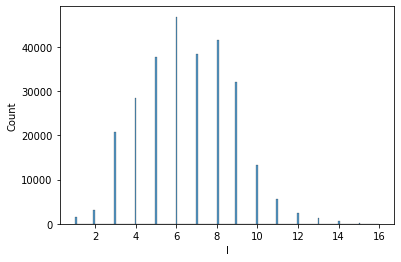

In [31]:
cent = '17'
path_df = lenght_all_pairs_shortest_path(cent_nets[cent])
cent_max_diameter = path_df['l'].max()
print('cent_diameter:', cent_max_diameter, 'from', len(path_df), 'all-pairs-paths')
sns.histplot(path_df['l'])

max tree diameter: 8.0


<AxesSubplot:xlabel='diameter from all directed paths', ylabel='Count'>

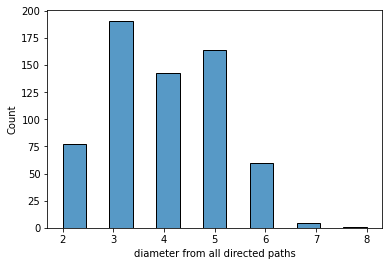

In [32]:
print('max tree diameter:', sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].max())
sns.histplot(sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'])

In [33]:
path_df[path_df['l'] == cent_max_diameter].drop_duplicates('p')

,l,p
131893,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N graf', 'PR von', 'N reich', 'PR wegen', 'N auffhebung', 'N belagerung', 'PR vor', 'N ritter', 'AJ bast']"
131894,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS finden', 'N meile', 'AJ halbe']"
131895,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS achten', 'AD hoch', 'AD sehr']"
131896,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS schicken', 'CJ als', 'N gesandter']"
131897,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS verzücken', 'N prediger', 'AJ tarsenisch']"
191536,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N graf', 'PR von', 'N reich', 'PR wegen', 'N auffhebung', 'N belagerung', 'PR vor', 'N ritter', 'AJ bast']"
191537,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS finden', 'N meile', 'AJ halbe']"
191538,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS achten', 'AD hoch', 'AD sehr']"
191539,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS schicken', 'CJ als', 'N gesandter']"
191540,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS verzücken', 'N prediger', 'AJ tarsenisch']"


# Other Network Charachtristics

In [83]:
for cent in cent_nets.keys():
#     cent = '14E'

    print('-------cent:', cent, '---------')

    G = cent_nets[cent]
    G_undirected = G.to_undirected()

#     print('N: {} E: {} <k_in>: {} <k_out>: {} <k>: {} <c>: {} <l>: {}'.format(
#         G_undirected.number_of_nodes(),
#         G_undirected.number_of_edges(),
#         round(np.mean([x[1] for x in G.in_degree()]), 2),
#         round(np.mean([x[1] for x in G.out_degree()]), 2),
#         round(np.mean([x[1] for x in G.degree()]), 2),
#         round(nx.average_clustering(G_undirected), 2),
#         round(nx.average_shortest_path_length(
#             G_undirected, 
#     #         weight='frequency'
#         ), 2)
#     ))

    print('N: {} E: {} <k>: {} <c>: {} <l>: {}'.format(
        G_undirected.number_of_nodes(),
        G_undirected.number_of_edges(),
        round(np.mean([x[1] for x in G.degree()]), 2),
        round(nx.average_clustering(G_undirected), 2),
        round(nx.average_shortest_path_length(
            G_undirected, 
    #         weight='frequency'
        ), 2)
    ))
    
    pass


# <c>: 0.07 <l>: 3.434273723287176
# <c>: 0.07 <l>: 3.780058805170913 weighted
# print(np.mean([x[1] for x in G.in_degree()]))
# print(np.mean([x[1] for x in G.out_degree()]))
# G.degree()

-------cent: 11 ---------
N: 411 E: 723 <k>: 3.52 <c>: 0.06 <l>: 3.24
-------cent: 12 ---------
N: 434 E: 803 <k>: 3.7 <c>: 0.05 <l>: 3.21
-------cent: 13 ---------
N: 697 E: 1325 <k>: 3.8 <c>: 0.05 <l>: 3.07
-------cent: 14E ---------
N: 686 E: 1321 <k>: 3.85 <c>: 0.14 <l>: 2.99
-------cent: 14L ---------
N: 751 E: 1585 <k>: 4.22 <c>: 0.08 <l>: 3.08
-------cent: 15 ---------
N: 735 E: 1422 <k>: 3.87 <c>: 0.05 <l>: 3.18
-------cent: 16 ---------
N: 1187 E: 2446 <k>: 4.12 <c>: 0.07 <l>: 3.26
-------cent: 17 ---------
N: 1561 E: 3076 <k>: 3.95 <c>: 0.07 <l>: 3.43


# Analysis of Hirearchy

- using Graph Hierarchy https://github.com/shuaib7860/GraphHierarchy

## Nodal Measures: Hirearchichal Levels
- Hierarchical levels is a generalisation of the notion of trophic levels and describes each vertex’s rank with respect to
“enegry” or “information” flow.
- Influence centrality is a measure of a vertex’s ability to influence the long term state of the graph.
- The democracy coefficient measures the feedback that is present in the graph.
- The hierarchical incoherence parameter is a straightforward generalisation of trophic incoherence.

In [33]:
h_measures_df = []

for cent, G in tqdm(cent_nets.items()):
    
    tmp_df = pd.concat([
            
            pd.Series(
                list(G.nodes), 
                name='node'
            ),
        
            pd.Series(
                gh.hierarchical_levels(G, weight='frequency'), 
                name='hierarchical_levels'
            )
        ], axis=1
    )
    
    tmp_df['cent'] = cent
    
    f_hierarchical_levels, f_influence_centrality, f_hierarchical_diff_adj_sparse, f_democracy_coefficient, f_hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    b_hierarchical_levels, b_influence_centrality, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    tmp_df['f_hierarchical_levels'] = f_hierarchical_levels
    tmp_df['b_hierarchical_levels'] = b_hierarchical_levels
    
    tmp_df['f_influence_centrality'] = f_influence_centrality
    tmp_df['b_influence_centrality'] = b_influence_centrality
    
    tmp_df['f_democracy_coefficient'] = f_democracy_coefficient
    tmp_df['b_democracy_coefficient'] = b_democracy_coefficient
    
    tmp_df['f_hierarchical_incoherence'] = f_hierarchical_incoherence
    tmp_df['b_hierarchical_incoherence'] = b_hierarchical_incoherence
    
    path_df = lenght_all_pairs_shortest_path(G)
    tmp_df['diameter directed'] = path_df['l'].max()

    
    tmp_df['diameter undirected'] = None
    if False:
        G_u = G.to_undirected()
        Gcc = sorted(nx.connected_components(G_u), key=len, reverse=True)
        giant = G_u.subgraph(Gcc[0])
        tmp_df['diameter undirected'] = nx.diameter(giant)
        pass
    
    
    tmp_df = pd.merge(
        pd.DataFrame(G.out_degree(), columns=['node', 'out_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    tmp_df = pd.merge(
        pd.DataFrame(G.in_degree(), columns=['node', 'in_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    
    h_measures_df.append(tmp_df)
    
    del path_df
#     break
    pass
    
h_measures_df = pd.concat(h_measures_df).reset_index(drop=True)
len(h_measures_df)

# cent_to_num = {
#     '11': 11.0, '12': 12.0, '13': 13.0, 'E14': 14.1, 'L14': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
# }

h_measures_df['cent_num'] = h_measures_df['cent'].map(centuries)

h_measures_df.insert(1, 'node func', h_measures_df['node'].apply(lambda x: x.split(' ')[0]))
h_measures_df.insert(4, 'degree', h_measures_df['in_degree'] + h_measures_df['out_degree'])

h_measures_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.42s/it]


,node,node func,in_degree,out_degree,degree,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,diameter undirected,cent_num
0,AX werden,AX,0,181,181,-1.333582,11,-1.707885,0.959280,1.000000e+00,-1.230676e-10,3.007827e-08,-1.096426e-07,0.533807,0.780024,7,None,11.0
1,PP er,PP,22,1,23,0.505575,11,-0.451650,-1.462800,-4.148755e-09,-4.491530e-06,3.007827e-08,-1.096426e-07,0.533807,0.780024,7,None,11.0
2,V werden,V,0,70,70,-0.885791,11,-1.282140,0.489441,1.000000e+00,9.247726e-08,3.007827e-08,-1.096426e-07,0.533807,0.780024,7,None,11.0
3,AX sin,AX,0,10,10,-1.691083,11,-2.313213,1.068954,1.000000e+00,1.163435e-08,3.007827e-08,-1.096426e-07,0.533807,0.780024,7,None,11.0
4,PCPS werden,PCPS,1,14,15,-1.135712,11,-1.313213,0.958211,-7.030483e-08,2.405827e-08,3.007827e-08,-1.096426e-07,0.533807,0.780024,7,None,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,AJ unein,AJ,1,0,1,-0.285331,17,-0.578614,-0.007952,-1.069302e-05,1.000000e+00,6.236148e-07,1.347075e-08,0.604562,0.772745,16,None,17.0
6458,AJ ungedultig,AJ,1,0,1,-0.285331,17,-0.578614,-0.007952,-1.069302e-05,1.000000e+00,6.236148e-07,1.347075e-08,0.604562,0.772745,16,None,17.0
6459,AJ unlustig,AJ,1,0,1,-0.285331,17,-0.578614,-0.007952,-1.069302e-05,1.000000e+00,6.236148e-07,1.347075e-08,0.604562,0.772745,16,None,17.0
6460,N gleich,N,1,0,1,-0.285331,17,-0.578614,-0.007952,-1.069302e-05,1.000000e+00,6.236148e-07,1.347075e-08,0.604562,0.772745,16,None,17.0


In [34]:
'''
CORRELATION TEST
https://realpython.com/numpy-scipy-pandas-correlation-python/
'''

col_1 = ['', 'in_degree', 'out_degree', 'degree'][1]
col_2 = ['',
    'f_hierarchical_levels', 'b_hierarchical_levels', 'hierarchical_levels',
    'f_influence_centrality', 'b_influence_centrality'
][1]

print('Spearmanr Correlation between "{}" and "{}"'.format(col_1, col_2))

for cent_num in h_measures_df['cent_num'].unique():
    df = h_measures_df[h_measures_df['cent_num'] == cent_num]

    print('cent: {} | {}'.format(cent_num, stats.spearmanr(df[col_1], df[col_2])))
# diameter

print('cent: ALL | {}'.format(stats.spearmanr(h_measures_df[col_1], h_measures_df[col_2])))

Spearmanr Correlation between "in_degree" and "f_hierarchical_levels"
cent: 11.0 | SpearmanrResult(correlation=0.2578245196876567, pvalue=1.1524976584137971e-07)
cent: 12.0 | SpearmanrResult(correlation=0.2678532655853882, pvalue=1.4455888874464201e-08)
cent: 13.0 | SpearmanrResult(correlation=0.3118924891724645, pvalue=3.438655258535114e-17)
cent: 14.1 | SpearmanrResult(correlation=0.23888006946875862, pvalue=2.3396106456398827e-10)
cent: 14.2 | SpearmanrResult(correlation=0.2596722786100057, pvalue=4.877771598478021e-13)
cent: 15.0 | SpearmanrResult(correlation=0.24140615689846792, pvalue=3.313396193175812e-11)
cent: 16.0 | SpearmanrResult(correlation=0.12552436982619702, pvalue=1.4425465923649808e-05)
cent: 17.0 | SpearmanrResult(correlation=0.15098264072700884, pvalue=2.036543665112915e-09)
cent: ALL | SpearmanrResult(correlation=0.18622827605469328, pvalue=1.628592092620778e-51)


## Validation Node Func

In [35]:
'''
ANOTHER VALIDATION
TODO NOTE: add a column to check number of times function is used
'''

func_frac_df = h_measures_df.groupby(['node func', 'cent']).agg(node_count_func = ('node func', np.size))

func_frac_df['node frac'] = func_frac_df['node_count_func'] / len(h_measures_df)

func_frac_df = func_frac_df.sort_values(by='node frac', ascending=True)

if True:
    func_frac_df.reset_index().to_excel(
        path_results_output + f'node_func_possible_more_bugs_enforceSingleFunc_{enforce_single_function}.xlsx'
    )

print('Num node functions:', len(func_frac_df.reset_index()['node func'].unique()))

if False:
    path_export = f'unique_node_functions_enforceSingleFunc_{enforce_single_function}_agg_cent.xlsx'
    
    (
        func_frac_df.reset_index()
        .groupby('node func')
        .agg({'node_count_func': np.sum})
        .sort_values(by='node_count_func', ascending=True)
        .to_excel(path_export)
    )
    
    print(path_export)
    
    path_export = f'unique_node_functions_enforceSingleFunc_{enforce_single_function}.xlsx'
    func_frac_df.reset_index().sort_values(by='node_count_func', ascending=True).to_excel(path_export)
    
    print(path_export)
    pass

func_frac_df

Num node functions: 18


node_count_func  node frac
node func cent                            
PCPR      11    1                0.000155 
          12    1                0.000155 
PK        16    1                0.000155 
          15    1                0.000155 
DM        14L   1                0.000155 
          15    1                0.000155 
IV        11    1                0.000155 
RP        14E   1                0.000155 
          13    1                0.000155 
          12    1                0.000155 
AR        11    1                0.000155 
CJ        12    1                0.000155 
RP        15    1                0.000155 
          11    1                0.000155 
RX        14L   1                0.000155 
          15    1                0.000155 
          16    1                0.000155 
          17    1                0.000155 
SJ        17    1                0.000155 
V         15    1                0.000155 
          14L   1                0.000155 
          14E   1                0.000155 
          13    1                0.000155 
PK        12    2                0.000310 
CJ        13    2                0.000310 
IV        13    2                0.000310 
PK        11    2                0.000310 
V         16    2                0.000310 
PK        14E   2                0.000310 
          13    2                0.000310 
PCPR      15    2                0.000310 
CJ        11    2                0.000310 
V         17    2                0.000310 
AX        15    2                0.000310 
          14L   2                0.000310 
V         12    2                0.000310 
          11    2                0.000310 
AR        13    2                0.000310 
          14E   2                0.000310 
AX        13    2                0.000310 
          12    2                0.000310 
          11    2                0.000310 
AR        14L   2                0.000310 
PK        17    2                0.000310 
AX        16    3                0.000464 
RP        16    3                0.000464 
          14L   3                0.000464 
AR        12    3                0.000464 
AX        17    3                0.000464 
AR        15    3                0.000464 
PK        14L   3                0.000464 
CJ        14L   3                0.000464 
AX        14E   3                0.000464 
CJ        16    3                0.000464 
MV        14L   4                0.000619 
CJ        15    4                0.000619 
MV        12    4                0.000619 
CJ        14E   4                0.000619 
DM        11    4                0.000619 
          16    4                0.000619 
MV        11    4                0.000619 
          13    5                0.000774 
          14E   5                0.000774 
IV        12    5                0.000774 
MV        15    5                0.000774 
          16    5                0.000774 
          17    6                0.000929 
CJ        17    6                0.000929 
RP        17    6                0.000929 
DM        12    6                0.000929 
AR        16    6                0.000929 
PP        12    7                0.001083 
DM        13    7                0.001083 
          14E   7                0.001083 
          17    8                0.001238 
AR        17    8                0.001238 
PP        11    8                0.001238 
PR        12    10               0.001548 
PP        14E   10               0.001548 
          13    11               0.001702 
          15    11               0.001702 
          14L   11               0.001702 
PR        11    12               0.001857 
IV        14E   13               0.002012 
PCPR      14L   13               0.002012 
PR        14E   13               0.002012 
PP        17    14               0.002167 
PCPR      14E   15               0.002321 
PR        13    16               0.002476 
          15    16               0.002476 
          14L   17               0.002631 
PCPR      13    1

In [36]:
h_measures_df

# f_democracy_coefficient

h_measures_df[h_measures_df['f_influence_centrality'] > 0.1][['node', 'cent', 'f_influence_centrality', 'f_hierarchical_levels']]

,node,cent,f_influence_centrality,f_hierarchical_levels
0,AX werden,11,1.0,-1.707885
2,V werden,11,1.0,-1.282140
3,AX sin,11,1.0,-2.313213
7,MV mögen,11,1.0,-2.825624
10,MV wellen,11,1.0,-2.342037
12,MV sollen,11,1.0,-1.403192
231,MV müssen,11,1.0,-0.296942
410,V wesen,11,1.0,-0.041501
411,AX werden,12,1.0,-1.619974
413,MV sollen,12,1.0,-2.192798


In [37]:
if True:
    h_measures_df.to_csv(path_data_explorer_data + 'hierarchical_metrics_german.csv')
    h_measures_df.to_excel(path_results_output + 'hierarchical_metrics_german.xlsx')
    
# if False:
#     h_measures_df = pd.read_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')

In [38]:
print(h_measures_df['cent'].value_counts())
h_measures_df.columns

17     1561
16     1187
14L    751 
15     735 
13     697 
14E    686 
12     434 
11     411 
Name: cent, dtype: int64


Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

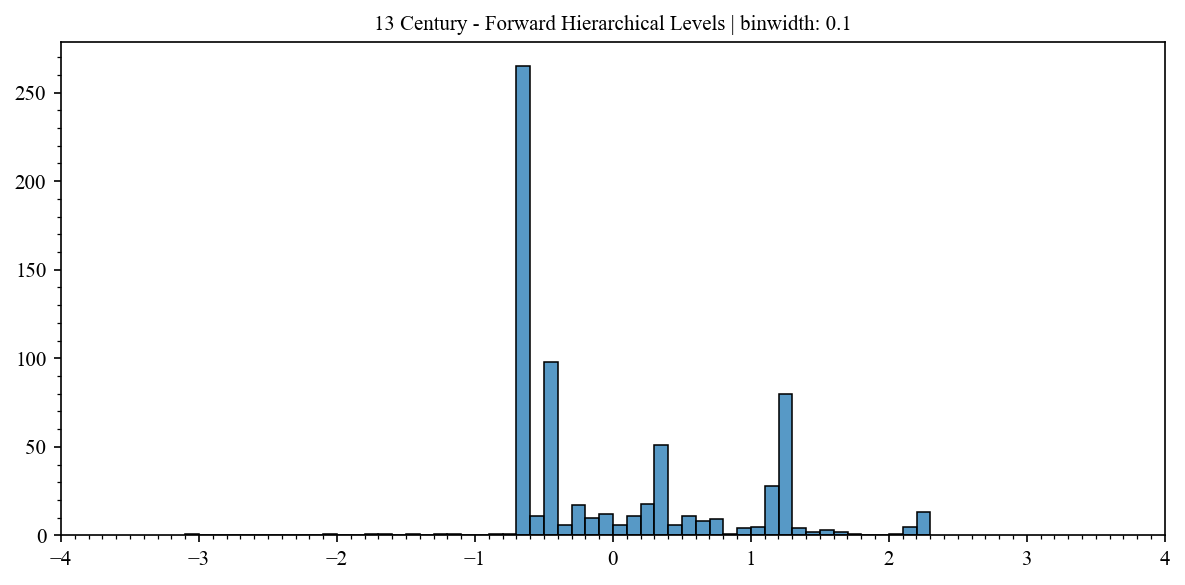

In [39]:
def plot_hirearchy_measure_single_cent(h_measures_df, cent, binwidth, figsize):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    plt.figure(figsize=figsize, dpi=150)

    h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

    g = sns.histplot(
        data=h_levels_tmp, x='f_hierarchical_levels', binwidth=binwidth
    )
    
    g.set_title('{} Century - Forward Hierarchical Levels | binwidth: {}'.format(cent, binwidth), loc='center')
    g.set(xlabel='', ylabel='', xlim=(-4, 4))
    
    g.xaxis.set_major_locator(plt.MultipleLocator(1))
    g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    
    g.yaxis.set_major_locator(plt.MultipleLocator(50))
    g.yaxis.set_minor_locator(plt.MultipleLocator(10))

    plt.tight_layout()

    pass

plot_hirearchy_measure_single_cent(h_measures_df=h_measures_df, binwidth=0.1, cent='13', figsize=(8,4))

8it [00:01,  5.61it/s]


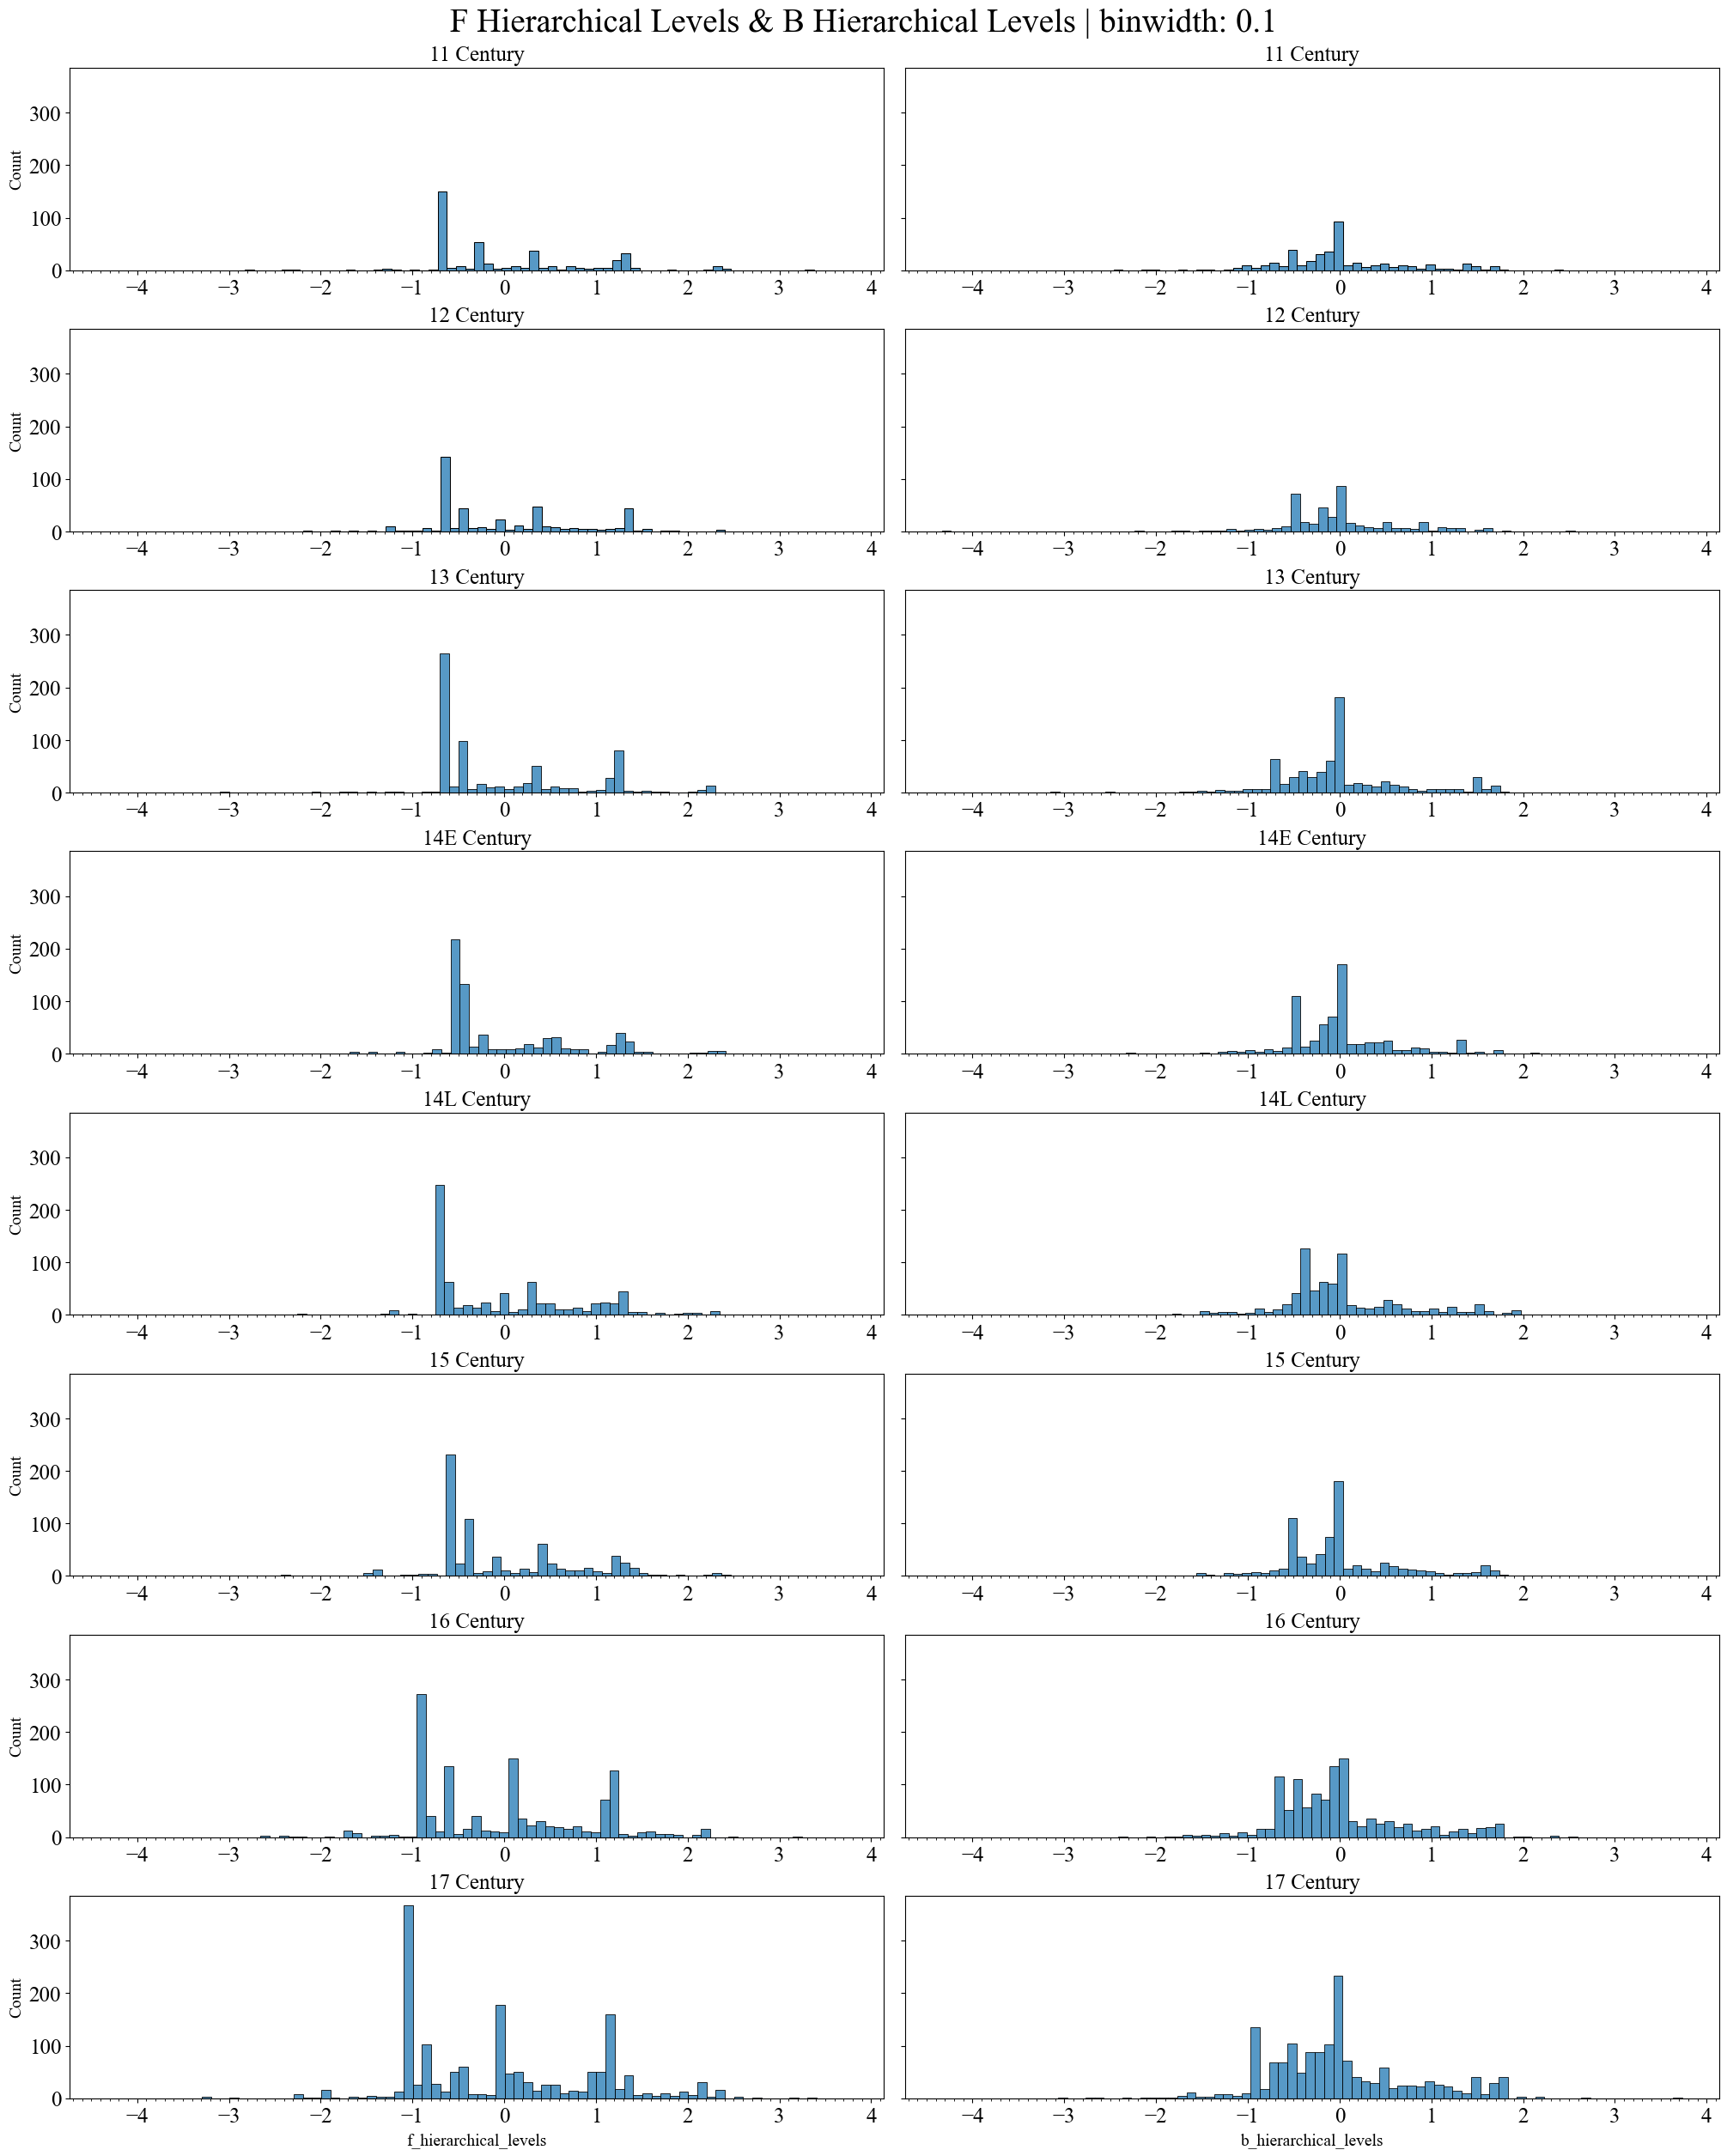

In [66]:
def plot_hirearchy_measure(h_measures_df, binwidth, func_names, ylim_dict=None):
    SMALL_SIZE = 18
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 28

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    fig, axes = plt.subplots(nrows=len(cent_nets.keys()), ncols=2, constrained_layout=True,
        sharex=True, sharey=True, dpi=100, figsize=(20, 25))

    fig.suptitle('{} | binwidth: {}'.format(
        ' & '.join(func_names).replace('_', ' ').title(), binwidth
    ))
    
    cents = list(cent_nets.keys())
    
    for a in fig.axes:
        a.tick_params(
            axis='x',           # changes apply to the x-axis
            which='both',       # both major and minor ticks are affected
            bottom=True,
            top=False,
            labelbottom=True   # labels along the bottom edge are on
        )    
    
    for row, cent in tqdm(enumerate(cents)):

        h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

        g = sns.histplot(
            data=h_levels_tmp, x=func_names[0],
            ax=axes[row, 0], binwidth=binwidth
        )
        
        g.set_title('{} Century'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))
#         print(ylim_dict[binwidth])
        '''-------------------------------'''
        g = sns.histplot(
            data=h_levels_tmp, x= func_names[1],
            ax=axes[row, 1], binwidth=binwidth
        )
        g.set_title('{} Century'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))

        pass
    pass

binwidth = [0.1, None][0]
# func_name = ['hierarchical_levels', 'forward_hierarchical_levels'][1]
func_names = [
    ('hierarchical_levels', 'f_hierarchical_levels'),
    ('hierarchical_levels', 'b_hierarchical_levels'),
    ('f_hierarchical_levels', 'b_hierarchical_levels'),
    
#     ('f_influence_centrality', 'f_hierarchical_levels')
][-1]
# ylim_dicts={
#     ('forward_hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {
#         0.25:300, 0.5: 250, 0.75: 300, 1.0: 350, None: 400},
#     ('hierarchical_levels weighted', 'forward_hierarchical_levels weighted'): {None: 400},
#     ('hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {None: 400},
# }

plot_hirearchy_measure(h_measures_df=h_measures_df, 
                       binwidth=binwidth, 
#                        ylim_dict=ylim_dicts[func_names], 
                       func_names=func_names)

In [41]:
h_measures_df.describe()

,in_degree,out_degree,degree,hierarchical_levels,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,cent_num
count,6462.000000,6462.000000,6462.000000,6.462000e+03,6.462000e+03,6.462000e+03,6.462000e+03,6.462000e+03,6.462000e+03,6.462000e+03,6462.000000,6462.000000,6462.000000,6462.000000
mean,1.967348,1.967348,3.934695,4.101400e-16,9.049469e-16,1.052839e-16,1.114305e-02,4.343854e-01,2.972243e-07,9.313729e-05,0.529633,0.743552,11.504952,14.806685
std,6.328495,13.115704,14.938601,6.769909e-01,8.829322e-01,6.874664e-01,1.049743e-01,4.957146e-01,2.453824e-07,2.570526e-04,0.046942,0.144910,4.399936,1.824009
min,0.000000,0.000000,1.000000,-2.531044e+00,-3.294832e+00,-4.333861e+00,-2.702120e-04,-1.083478e-03,-1.253540e-07,-2.365714e-07,0.470319,0.570225,6.000000,11.000000
25%,1.000000,0.000000,1.000000,-4.189229e-01,-6.656152e-01,-4.405140e-01,-4.418312e-06,-5.160538e-07,1.199961e-07,-2.009242e-07,0.495580,0.674684,8.000000,14.100000
50%,1.000000,1.000000,2.000000,-9.030295e-02,-2.821418e-01,-4.535616e-02,1.358604e-07,2.248305e-05,3.114896e-07,1.347075e-08,0.514486,0.723845,10.000000,15.000000
75%,1.000000,2.000000,3.000000,4.829407e-01,6.187722e-01,2.404416e-01,6.314661e-06,1.000000e+00,5.107394e-07,4.664462e-08,0.535443,0.772745,16.000000,16.000000
max,261.000000,506.000000,506.000000,2.169387e+00,3.357126e+00,3.664244e+00,1.000000e+00,1.000002e+00,6.236148e-07,8.019387e-04,0.604562,1.220972,17.000000,17.000000


In [42]:
# cen = '11'
# plt.figure(figsize=(15,8))
# sns.histplot(data=h_measures_df[h_measures_df['cent'] == cent], x='f_influence_centrality')

In [43]:
h_measures_df.columns

Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

## FHL

In [44]:
h_measures_df['cent_FHL'] = h_measures_df.apply(lambda r: (r['cent'], round(r['f_hierarchical_levels'], 3)), axis=1)

In [45]:
nodes_FHL_df = (
    h_measures_df
    .groupby('node')
    .agg(
        FHL_avg=('f_hierarchical_levels', np.mean), 
        FHL_std=('f_hierarchical_levels', np.std), 
        count_cent=('cent', np.size),
        cent_FHL=('cent_FHL', lambda x: list(x))
    )
    .sort_values(by='FHL_std', ascending=False)
)

if True:
    nodes_FHL_df.to_excel(path_results_output + '/nodes_FHL_cent_variability.xlsx')

#     nodes_FHL_df[nodes_FHL_df.index == 'N geist']
nodes_FHL_df

,FHL_avg,FHL_std,count_cent,cent_FHL
node,,,,
N gefahr,-0.344949,2.248652,2,"[(16, 1.245), (17, -1.935)]"
N buchstabe,-0.115631,2.155040,2,"[(15, 1.408), (16, -1.639)]"
N gedächtnis,-0.201691,2.053948,2,"[(15, 1.251), (16, -1.654)]"
N tat,0.782099,2.047376,2,"[(14L, -0.666), (16, 2.23)]"
AJ göttlich,0.740059,1.950371,2,"[(16, -0.639), (17, 2.119)]"
...,...,...,...,...
SJ ob,0.270871,NaN,1,"[(17, 0.271)]"
V haben,-1.011269,NaN,1,"[(17, -1.011)]"
V lazen,-0.340664,NaN,1,"[(12, -0.341)]"


In [46]:
print('Number of nodes exists only single century (std=0):', sum(nodes_FHL_df['FHL_std'].isnull()), 'from', len(nodes_FHL_df))

for r in reversed(np.arange(0.5, 2.1, 0.25)):

    print('Number of Nodes with std >= {}: {} from {} | Exists in {} centuries'.format(
        r,
        sum(nodes_FHL_df['FHL_std'] >= r),
        sum(~nodes_FHL_df['FHL_std'].isnull()),
        round(nodes_FHL_df[nodes_FHL_df['FHL_std'] >= r]['count_cent'].mean(), 2)
    ))

Number of nodes exists only single century (std=0): 3295 from 4361
Number of Nodes with std >= 2.0: 4 from 1066 | Exists in 2.0 centuries
Number of Nodes with std >= 1.75: 12 from 1066 | Exists in 2.0 centuries
Number of Nodes with std >= 1.5: 23 from 1066 | Exists in 2.04 centuries
Number of Nodes with std >= 1.25: 66 from 1066 | Exists in 2.2 centuries
Number of Nodes with std >= 1.0: 129 from 1066 | Exists in 2.47 centuries
Number of Nodes with std >= 0.75: 206 from 1066 | Exists in 2.83 centuries
Number of Nodes with std >= 0.5: 335 from 1066 | Exists in 3.0 centuries


## Influence Centrality

In [47]:
'''Forward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['f_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if True:
    head_f_influence.to_excel(path_results_output + 'influence_cent_forward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,14E,14L,15,16,17,sum
node,,,,,,,,,
MV müssen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV sollen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX sin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
V werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV wellen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV mögen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV können,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,5.0
AX haben,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [48]:
'''Backward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['b_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if True:
    head_f_influence.to_excel(path_results_output + 'influence_cent_backward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,14E,14L,15,16,17,sum
node,,,,,,,,,
AR der,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
RP der,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ dise,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AD so,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...
AJ strebig,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
AJ still,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
AJ stet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [49]:
[n for n in nodes_all_cent if 'werden' in n]

['IV werden', 'V werden', 'AX werden', 'PCPS werden']

[None, None]

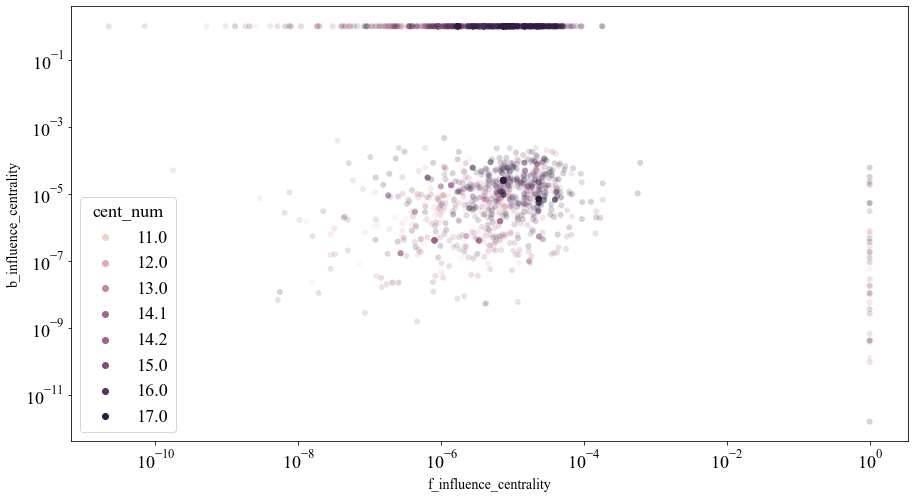

In [50]:
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=h_measures_df, x='f_influence_centrality', y='b_influence_centrality', 
                     hue='cent_num', alpha=0.2, linewidth=0, legend='full')

ax.set(xscale='log', yscale='log')

# h_measures_df['f_influence_centrality']

Text(0.5, 1.0, 'f_influence_centrality')

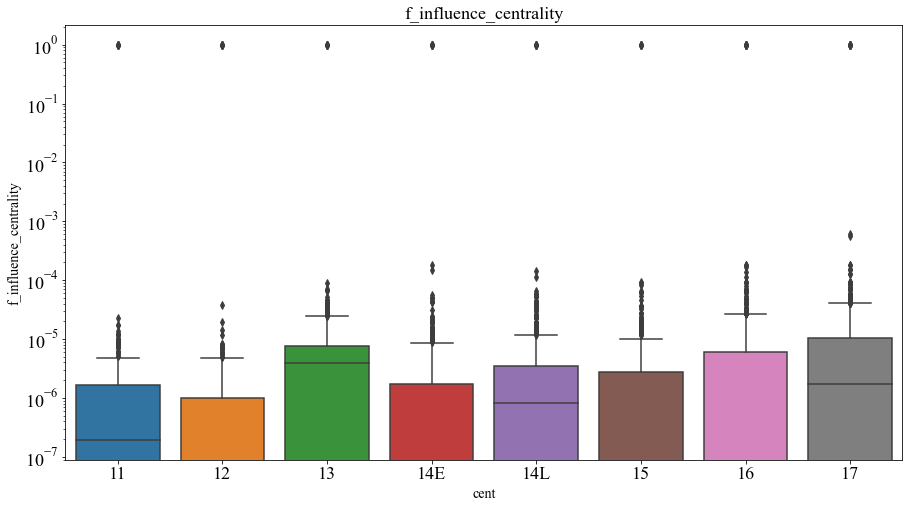

In [51]:
measure = ['f_influence_centrality'][0]

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=h_measures_df, y=measure, x='cent')
ax.set(yscale="log")
ax.set_title(measure)

<AxesSubplot:xlabel='f_hierarchical_levels', ylabel='Count'>

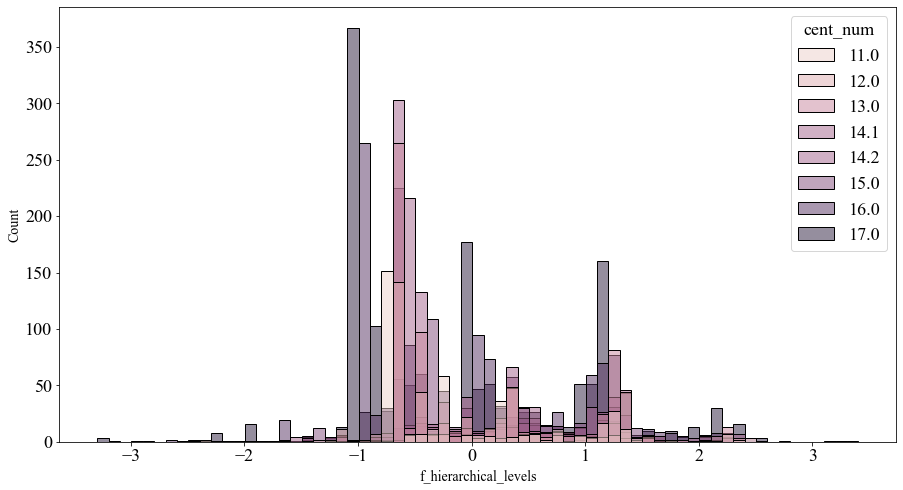

In [52]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='f_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='b_hierarchical_levels', ylabel='Count'>

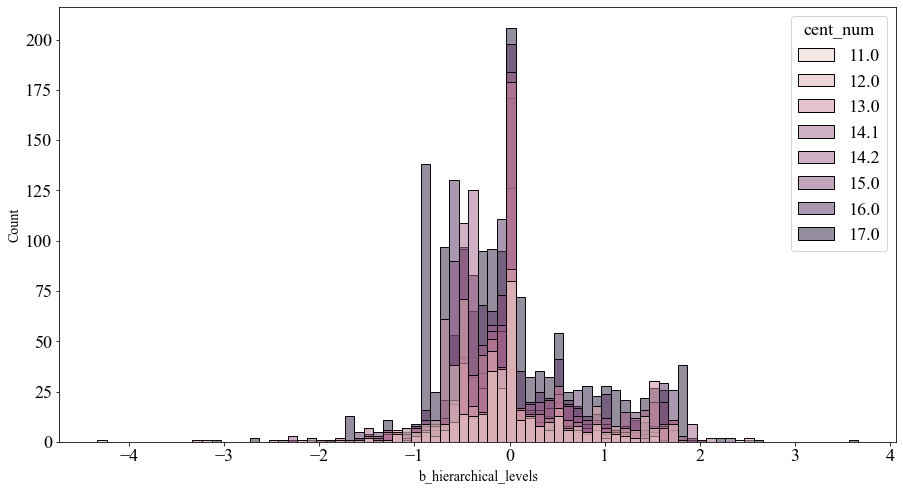

In [53]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='b_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='hierarchical_levels', ylabel='Count'>

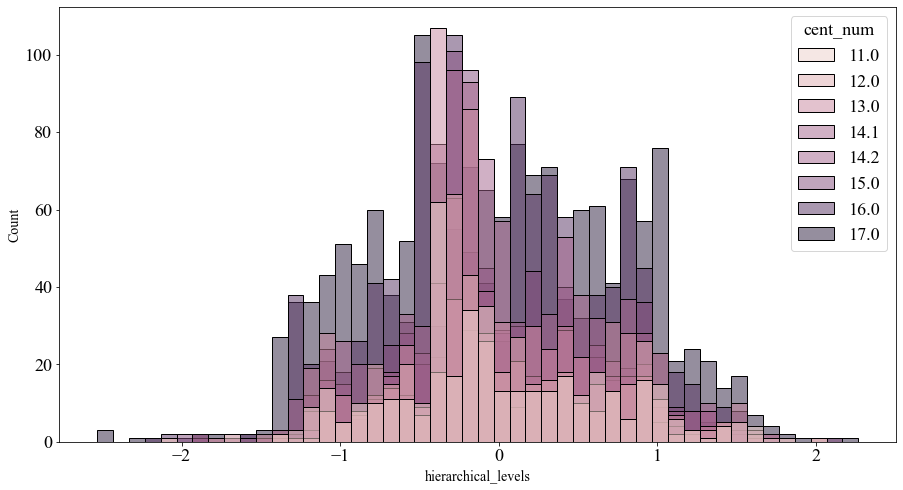

In [54]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='hierarchical_levels', hue='cent_num', binwidth=0.1)

In [55]:
# plt.figure(figsize=(15,8))
# sns.histplot(
#     data=h_levels_df[h_levels_df['cent'].isin(['11', '17'])], 
#     x='hierarchical_levels', hue='cent')

## Global Measures: Democracy Coeff and Hierarchical Incoherence

In [56]:
dem_forw_df = []

col_weight = 'frequency'

for cent, G in tqdm(cent_nets.items()):
    FHD_adj, FHD_mean, FHD_std = gh.forward_hierarchical_incoherence(G, weight=col_weight)
    
#     b_hierarchical_level_vector, b_influence_centrality_vector, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    hierarchical_level_vector, influence_centrality_vector, hierarchical_diff_adj_sparse, democracy_coefficient, hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight=col_weight)
    
    dem_forw_df.append(
        {
            'cent': cent,
            'forward_hierarchical_incoherence avg': FHD_mean,
            'forward_hierarchical_incoherence std': FHD_std,
            'forward_democracy_coefficient': gh.forward_democracy_coefficient(G, weight=col_weight),
            'backward_democracy_coefficient': gh.backward_democracy_coefficient(G, weight=col_weight),
            'democracy_coefficient': democracy_coefficient,
            'hierarchical_incoherence': hierarchical_incoherence
        }
    )
    
dem_forw_df = pd.DataFrame(dem_forw_df)
dem_forw_df['cent_num'] = dem_forw_df['cent'].map(centuries)
dem_forw_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.19it/s]


,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.533807,3.007827e-08,-1.096426e-07,3.007827e-08,0.533807,11.0
1,12,1.000000,0.514486,-1.253540e-07,4.664462e-08,-1.253540e-07,0.514486,12.0
2,13,0.999999,0.486245,5.107394e-07,7.291942e-08,5.107394e-07,0.486245,13.0
3,14E,1.000000,0.495580,9.865835e-09,-2.365714e-07,9.865835e-09,0.495580,14.1
4,14L,1.000000,0.500600,1.199961e-07,8.019387e-04,1.199961e-07,0.500600,14.2
5,15,1.000000,0.470319,2.267127e-07,-6.670978e-08,2.267127e-07,0.470319,15.0
6,16,1.000000,0.535443,3.114896e-07,-2.009242e-07,3.114896e-07,0.535443,16.0
7,17,0.999999,0.604562,6.236148e-07,1.347075e-08,6.236148e-07,0.604562,17.0


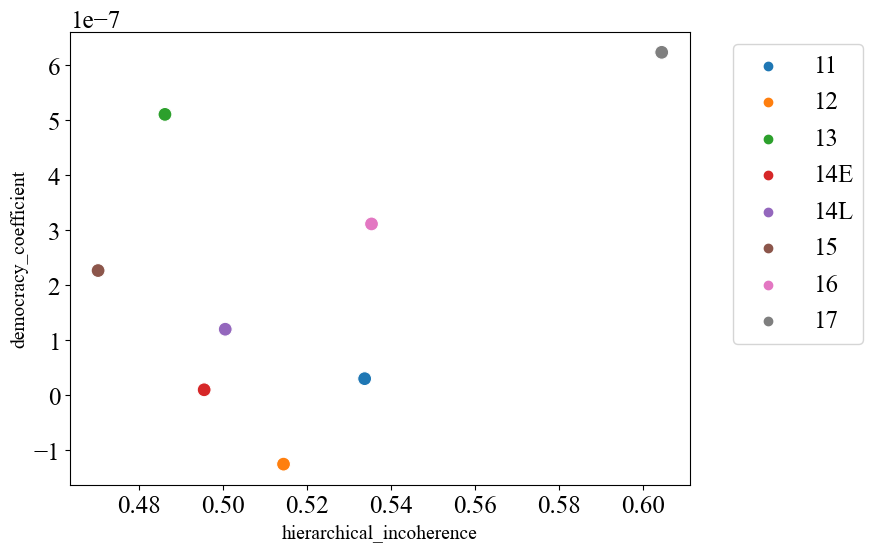

In [57]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=dem_forw_df, x="hierarchical_incoherence", y="democracy_coefficient", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1.0, 1.0, 0.3, 0))

In [58]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.533807,3.007827e-08,-1.096426e-07,3.007827e-08,0.533807,11.0
1,12,1.000000,0.514486,-1.253540e-07,4.664462e-08,-1.253540e-07,0.514486,12.0
2,13,0.999999,0.486245,5.107394e-07,7.291942e-08,5.107394e-07,0.486245,13.0
3,14E,1.000000,0.495580,9.865835e-09,-2.365714e-07,9.865835e-09,0.495580,14.1
4,14L,1.000000,0.500600,1.199961e-07,8.019387e-04,1.199961e-07,0.500600,14.2
5,15,1.000000,0.470319,2.267127e-07,-6.670978e-08,2.267127e-07,0.470319,15.0
6,16,1.000000,0.535443,3.114896e-07,-2.009242e-07,3.114896e-07,0.535443,16.0
7,17,0.999999,0.604562,6.236148e-07,1.347075e-08,6.236148e-07,0.604562,17.0


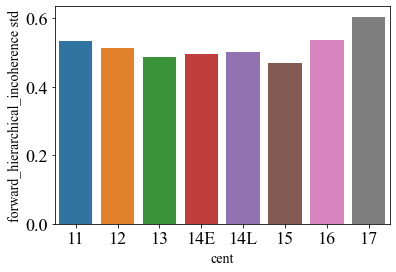

In [59]:
ax = sns.barplot(x="cent", y="forward_hierarchical_incoherence std", data=dem_forw_df)

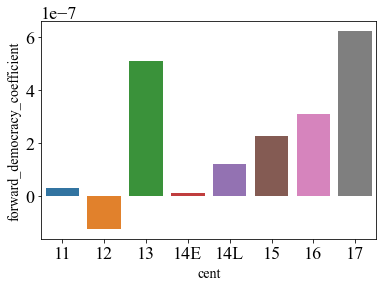

In [60]:
ax = sns.barplot(x="cent", y="forward_democracy_coefficient", data=dem_forw_df)

In [61]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.533807,3.007827e-08,-1.096426e-07,3.007827e-08,0.533807,11.0
1,12,1.000000,0.514486,-1.253540e-07,4.664462e-08,-1.253540e-07,0.514486,12.0
2,13,0.999999,0.486245,5.107394e-07,7.291942e-08,5.107394e-07,0.486245,13.0
3,14E,1.000000,0.495580,9.865835e-09,-2.365714e-07,9.865835e-09,0.495580,14.1
4,14L,1.000000,0.500600,1.199961e-07,8.019387e-04,1.199961e-07,0.500600,14.2
5,15,1.000000,0.470319,2.267127e-07,-6.670978e-08,2.267127e-07,0.470319,15.0
6,16,1.000000,0.535443,3.114896e-07,-2.009242e-07,3.114896e-07,0.535443,16.0
7,17,0.999999,0.604562,6.236148e-07,1.347075e-08,6.236148e-07,0.604562,17.0


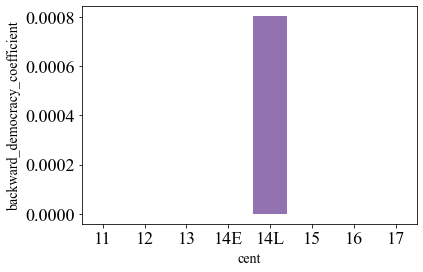

In [62]:
ax = sns.barplot(x="cent", y="backward_democracy_coefficient", data=dem_forw_df)

## Challenges

- https://stackoverflow.com/questions/57458789/get-bin-width-used-for-seaborn-plot
- ITS SO GOOD: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
- https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

In [63]:
raise Exception('The End!')

Exception: The End!

# [OLD] yFiles Hierarchical Layout

In [ ]:
path_yfiles_layout = 'D:/GoogleDrive/Research/Linguistic project/German/data/Hierarchical Layout yfiles/'

path_networks = OrderedDict()

path_networks['11'] = path_yfiles_layout + "/Cent11.cyjs" 
path_networks['12'] = path_yfiles_layout + "/Cent12.cyjs" 
path_networks['13'] = path_yfiles_layout + "/Cent13.cyjs" 
path_networks['14E'] = path_yfiles_layout + "/Cent14E.cyjs" 

path_networks['14L'] = path_yfiles_layout + "/Cent14L.cyjs" 
path_networks['15'] = path_yfiles_layout + "/Cent15.cyjs" 
path_networks['16'] = path_yfiles_layout + "/Cent16.cyjs" 
path_networks['17'] = path_yfiles_layout + "/Cent17.cyjs" 

In [ ]:
layouts = OrderedDict()
cen_layers = {}

for cent, path_layout in path_networks.items():
    f = open(path_layout, "r", encoding='utf-8')
    layouts[cent] = json.loads(f.read())
    
    cen_layers[cent] = []
    
    for node in layouts[cent]['elements']['nodes']:
        
        cen_layers[cent].append({
            'name': node['data']['name'],
            'x': node['position']['x'],
            'y': node['position']['y'],
            'y_round': round(node['position']['y'])
        })
        pass
    
    cen_layers[cent] = pd.DataFrame(cen_layers[cent])
    """Now convert unique y value to sequential layer number"""
    map_y_val_to_layer_num = {
        y: l + 1 for l, y in enumerate(sorted(set(cen_layers[cent]['y_round'])))
    }
    
    cen_layers[cent]['layer'] = cen_layers[cent]['y_round'].map(map_y_val_to_layer_num)
    
    cen_layers[cent] = cen_layers[cent].sort_values('layer').reset_index(drop=True)
#     break
    pass
# del layers
map_y_val_to_layer_num
cen_layers['17'].columns
# cen_layers.keys()

In [ ]:
cen_layer_count = []
for cen, cen_layer in cen_layers.items():
    cen_layer_count.append({
        'cent': cen,
        'num layers': cen_layer['layer'].max()
    })
    pass

cen_layer_count = pd.DataFrame(cen_layer_count)

cen_layers['cen_layer_count'] = cen_layer_count

cen_layers['cen_layer_count']

In [ ]:
%matplotlib inline

ax=sns.barplot(x="cent", y="num layers", data=cen_layer_count)
ax.set(ylim=(0, 30), title='Number of Layers in Each Century')

In [ ]:
save_xls(dfs_dict=cen_layers, 
         xls_path=path_yfiles_layout + '/all_cent_layers_yfiles.xlsx', 
         open=True)

# [OLD] Graph Hierarchy 
- How to draw netwrokx graph https://faculty.math.illinois.edu/~hirani/cbmg/graphs.html
- Add x-y axis when drawing with NetworkX https://stackoverflow.com/questions/56994061/how-to-make-x-and-y-axes-appear-when-using-networkx-and-matplotlib
- A cool toturial for visualization https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [ ]:

graph = nx.gnr_graph(20, 0.4)
nx.draw_networkx(graph)

In [ ]:
l = list(zip(
    graph.nodes(),
#     gh.forward_hierarchical_levels(graph)
    gh.hierarchical_levels(graph)
))

l.sort(key=lambda x: x[1])
l

In [ ]:
level_dict = {}
level_num = 0
prev_layer_level = None
offset = 0

for node, level in l:
    if prev_layer_level is not None:
        offset = 1 - (level - prev_layer_level)
    
#     print('l: ', level, 'o: ', offset)
    
    if level not in level_dict:
        level_dict[level] = []
        level_num += 1
        prev_layer_level = level
        pass
    
    level_dict[level].append(node)
#     print(level + (np.sign(level) * 1))
    graph.nodes[node]['pos'] = (
        (len(level_dict[level]) * 2) + random.uniform(-1, 1),
        level 
    )
    pass

# plt.figure(3,figsize=(12,12)) 

fig, ax = plt.subplots()
fig.set_dpi(150)
fig.set_size_inches(10,10)
pos=nx.get_node_attributes(graph,'pos')

plt.figure(3,figsize=(12,12)) 

nx.draw_networkx(graph, pos, ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [ ]:
print('levels: ', len(level_dict))

In [ ]:
node_l_dict = dict(l)
node_l_dict[0] - node_l_dict[1]

In [ ]:
gh.forward_hierarchical_differences(graph)


In [ ]:
(hierarchical_differences_sparse, 
 hierarchical_differences_mean, 
 hierarchical_differences_std) = gh.forward_hierarchical_incoherence(graph)

"""The standard deviation of the distribution is known as the forward hierarchical incoherence and is an important metric which gives a measure of a network's organisation and structure."""
print('mean:', hierarchical_differences_mean, 'std:' , hierarchical_differences_std)

In [ ]:
gh.forward_democracy_coefficient(graph)

In [ ]:
for node in graph.nodes:
    print(node, gh.node_forward_influence_centrality(graph, node))

In [ ]:
gh.forward_influence_centrality(graph)


In [ ]:
gh.hierarchical_levels(graph)
